In [ ]:
import torch
import math
import matplotlib.pyplot as plt
import seaborn as sns
from torch.distributions import Beta
eval_states = torch.load("Evaluation_States.pt",weights_only=True)
# :6 Init Joints Pos
# 6:9 Target Pos
# 9:11 object size (height, width)
# 11:14 object color


In [371]:
unseen = False
MaxSize = [0.6,1.0,1.0]   #Height, W/H, L/H
MinSize = [0.3,0.5,0.5]

if unseen:
    #object_width_updated = torch.rand_like(eval_states[:,0]) * 0.125 + 0.025  #smallBase *0.125 + 0.025
    #object_length_updated = torch.rand_like(eval_states[:,0]) * 0.125 + 0.025 #smallBase *0.125 + 0.025
    #object_height_updated = torch.rand_like(eval_states[:,0]) * 0.3 + 0.1   #smallBase *0.3 + 0.1
    object_height_updated = torch.rand_like(eval_states[:,0]) * (MaxSize[0] - MinSize[0]) + MinSize[0]
    object_widthRatio_updated = torch.rand_like(eval_states[:,0]) * (MaxSize[1] - MinSize[1]) + MinSize[1]
    object_lengthRatio_updated = torch.rand_like(eval_states[:,0]) * (MaxSize[2] - MinSize[2]) + MinSize[2]
else:
    #object_width_updated = torch.rand_like(eval_states[:,0]) * 0.05 + 0.05  #smallBase *0.125 + 0.025
    #object_length_updated = torch.rand_like(eval_states[:,0]) * 0.05 + 0.05 #smallBase *0.125 + 0.025
    #object_height_updated = torch.rand_like(eval_states[:,0]) * 0.2 + 0.1   #smallBase *0.3 + 0.1
    object_height_updated = torch.rand_like(eval_states[:,0]) * (MaxSize[0] - MinSize[0]) + MinSize[0]
    object_widthRatio_updated = torch.rand_like(eval_states[:,0]) * (MaxSize[1] - MinSize[1]) + MinSize[1]
    object_lengthRatio_updated = torch.rand_like(eval_states[:,0]) * (MaxSize[2] - MinSize[2]) + MinSize[2]

object_size_updated = torch.stack([object_height_updated, object_widthRatio_updated, object_lengthRatio_updated], dim=-1)
print(object_size_updated.min(0), object_size_updated.max(0))

torch.return_types.min(
values=tensor([0.3004, 0.5006, 0.5002], device='cuda:0'),
indices=tensor([ 28, 224, 129], device='cuda:0')) torch.return_types.max(
values=tensor([0.5990, 0.9979, 0.9977], device='cuda:0'),
indices=tensor([437,  15,  71], device='cuda:0'))


In [372]:
object_color = eval_states[:, 11:14].clone()
init_joint_pos = eval_states[:, :6].clone()

In [373]:
#shift height by robot base height (0.8)
target_pos = eval_states[:,6:9].clone()

print("min target pos: ", target_pos.min(0).values)
print("max target pos: ", target_pos.max(0).values)

n = target_pos.size(0)
tgt_radius_range = (0.7,0.9)
tgt_yaw_range = (-math.pi / 2, math.pi / 2)
tgt_pitch_range = (-math.pi / 12, 3*math.pi / 12) # orignally -math.pi / 6, math.pi / 6 --> for safety range changed to -math.pi / 12, 3*math.pi / 12

tgt_radius = torch.empty(n).uniform_(*tgt_radius_range)
tgt_yaw = torch.empty(n).uniform_(*tgt_yaw_range)
tgt_pitch = torch.empty(n).uniform_(*tgt_pitch_range)
x = tgt_radius * torch.cos(tgt_yaw) * torch.cos(tgt_pitch)
y = tgt_radius * torch.sin(tgt_yaw) * torch.cos(tgt_pitch)
z = tgt_radius * torch.sin(tgt_pitch)
tgt_pos_new = torch.stack([x,y,z], dim=-1)


print("min tgt pos new: ", tgt_pos_new.min(0).values)
print("max tgt pos new: ", tgt_pos_new.max(0).values)

target_pos = tgt_pos_new.to(target_pos.device)
#target_pos[:,2]= target_pos[:,2] - 0.8


min target pos:  tensor([ 0.0011, -0.8817,  0.3626], device='cuda:0')
max target pos:  tensor([0.8845, 0.8788, 1.2402], device='cuda:0')
min tgt pos new:  tensor([ 7.5533e-04, -8.7651e-01, -2.1946e-01])
max tgt pos new:  tensor([0.8914, 0.8692, 0.6344])


In [374]:
friction = torch.rand_like(eval_states[:, 13])*0.9 + 0.1
eval_states = torch.cat([init_joint_pos, target_pos, object_size_updated, object_color, friction.unsqueeze(-1)], dim=-1)

In [375]:
torch.save(eval_states, "eval_states_updated.pt")

In [376]:
print("min target pos: ", target_pos.min(0).values)
print("max target pos: ", target_pos.max(0).values)

min target pos:  tensor([ 7.5533e-04, -8.7651e-01, -2.1946e-01], device='cuda:0')
max target pos:  tensor([0.8914, 0.8692, 0.6344], device='cuda:0')


In [377]:
print("min joint post: ", init_joint_pos.min(0).values)
print("max joint post: ", init_joint_pos.max(0).values)

min joint post:  tensor([-1.5647, -1.4835,  0.4660, -1.4861,  1.5708,  0.0000], device='cuda:0')
max joint post:  tensor([ 1.5698, -0.1222,  2.8655, -0.0621,  1.5708,  0.0000], device='cuda:0')


In [378]:
n = 1000
tgt_radius_range = (0.7,0.9)
tgt_yaw_range = (-math.pi / 2, math.pi / 2)
tgt_pitch_range = (-math.pi / 6, math.pi / 6)

tgt_radius = torch.empty(n).uniform_(*tgt_radius_range)
tgt_yaw = torch.empty(n).uniform_(*tgt_yaw_range)
tgt_pitch = torch.empty(n).uniform_(*tgt_pitch_range)
x = tgt_radius * torch.cos(tgt_yaw) * torch.cos(tgt_pitch)
y = tgt_radius * torch.sin(tgt_yaw) * torch.cos(tgt_pitch)
z = tgt_radius * torch.sin(tgt_pitch)
tgt_pos_new = torch.stack([x,y,z], dim=-1)

print("min target pos new: ", tgt_pos_new.min(0).values)
print("max target pos new: ", tgt_pos_new.max(0).values)

min target pos new:  tensor([ 0.0020, -0.8848, -0.4445])
max target pos new:  tensor([0.8823, 0.8859, 0.4445])


In [379]:
n = 100000
init_joint_pos = torch.ones(n, 6)
init_joint_pos[:, 0] = init_joint_pos[:, 0] * 0.0
init_joint_pos[:, 1] = init_joint_pos[:, 1] * -math.pi / 4
init_joint_pos[:, 2] = init_joint_pos[:, 2] * math.pi / 2
init_joint_pos[:, 3] = init_joint_pos[:, 3] * -math.pi / 4
init_joint_pos[:, 4] = init_joint_pos[:, 4] * math.pi / 2
init_joint_pos[:, 5] = init_joint_pos[:, 5] * 0.0

init_joint_pos[:, 0] = init_joint_pos[:, 0] + math.pi * (torch.rand_like(init_joint_pos[:, 0]) - 0.5)
angle = math.pi / 4 *torch.rand_like(init_joint_pos[:, 0])
coeff1 = 2 * torch.rand_like(init_joint_pos[:, 0]) - 1 # why not  torch.rand_like(init_joint_pos[:, 0])
coeff2 = 2 * torch.rand_like(init_joint_pos[:, 0]) - 1
coeff3 = coeff1 + coeff2
init_joint_pos[:, 1] += coeff1 * angle
init_joint_pos[:, 3] += coeff2 * angle
init_joint_pos[:, 2] -= coeff3 * angle

print("min init Joint pos new: ", init_joint_pos.min(0).values)
print("max init Joint pos new: ", init_joint_pos.max(0).values)

min init Joint pos new:  tensor([-1.5708, -1.5662,  0.0824, -1.5605,  1.5708,  0.0000])
max init Joint pos new:  tensor([ 1.5708e+00, -3.8213e-03,  3.1059e+00, -7.1251e-04,  1.5708e+00,
         0.0000e+00])


### Sampling Approach

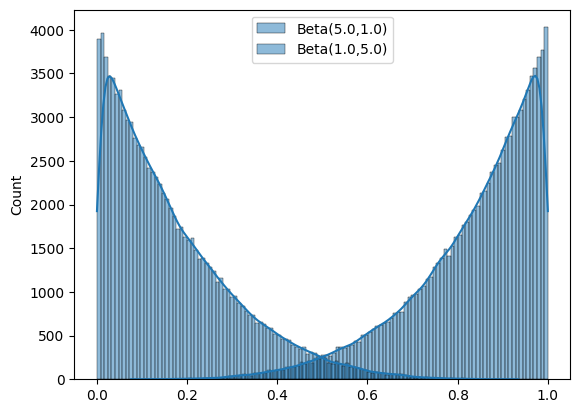

In [ ]:


n = 100000
a = torch.FloatTensor([5])
b = torch.FloatTensor([1])
dist_1 = Beta(a, b)
dist_2 = Beta(b, a) 
x = dist_1.sample((n,)).numpy() #+ dist_2.sample((n,)).numpy()
y = dist_2.sample((n,)).numpy()
sns.histplot(x, label=f'Beta({float(a)},{float(b)})', kde=True,color='red', edgecolor='black')
sns.histplot(y, label=f'Beta({float(b)},{float(a)})', kde=True,color='blue', edgecolor='black')

plt.legend()

In [381]:
n = 100000
init_joint_pos = torch.ones(n, 6)
init_joint_pos[:, 0] = init_joint_pos[:, 0] * 0.0
init_joint_pos[:, 1] = init_joint_pos[:, 1] * -math.pi / 4
init_joint_pos[:, 2] = init_joint_pos[:, 2] * math.pi / 2
init_joint_pos[:, 3] = init_joint_pos[:, 3] * -math.pi / 4
init_joint_pos[:, 4] = init_joint_pos[:, 4] * math.pi / 2
init_joint_pos[:, 5] = init_joint_pos[:, 5] * 0.0

<Axes: ylabel='Count'>

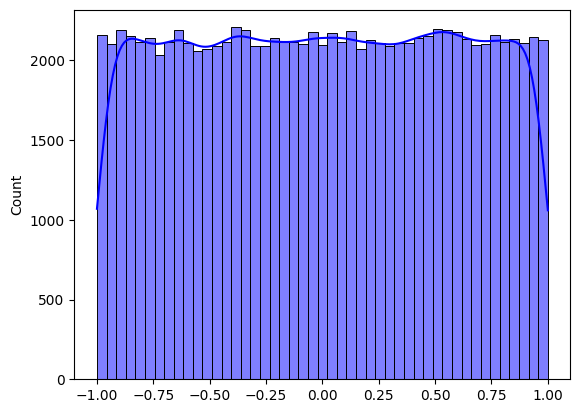

In [382]:
# unifrom sampling
joint1 = init_joint_pos[:, 0].clone() + math.pi * (torch.rand_like(init_joint_pos[:, 0]) - 0.5)
joint1 = joint1/(math.pi/2)
sns.histplot(joint1.cpu().numpy(), label='joint 1', color='blue', kde=True)
# edge case sampling using beta distributio


<Axes: ylabel='Count'>

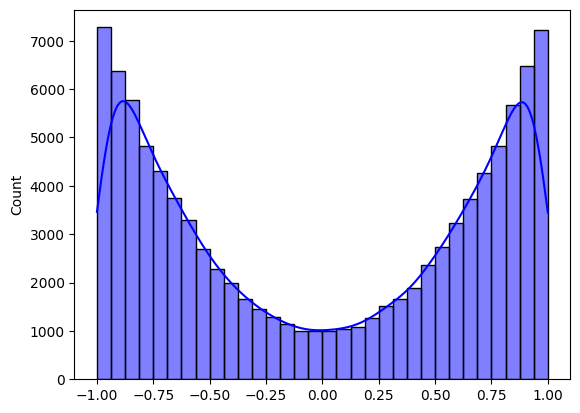

In [383]:
# unifrom sampling
n = init_joint_pos.shape[0]
a = 5
b = 1
dist_1 = Beta(a, b)
shift1 = torch.pi * (dist_1.sample((n,)).squeeze() - 0.5)
shift2 = -torch.pi * (dist_1.sample((n,)).squeeze() - 0.5)
sampledShift = torch.where(torch.rand(n) > 0.5, shift1, shift2)
joint1 = init_joint_pos[:, 0].clone() + sampledShift
joint1 = joint1/(torch.pi/2)
sns.histplot(joint1.cpu().numpy(), label='joint 1', color='blue', kde=True)
# edge case sampling using beta distributio


In [384]:
tgt_yaw_range = (-math.pi / 2, math.pi / 2)
env_ids = torch.arange(n)
if torch.rand(1) > 0.5:
    tgt_yaw = torch.empty(n).uniform_(*tgt_yaw_range)
else:
    tgt_yaw_set = torch.empty((n,10)).uniform_(*tgt_yaw_range)
    joint1_pos = init_joint_pos[env_ids, 0].unsqueeze(1).repeat(1, 10)
    print(joint1_pos.shape, tgt_yaw_set.shape)
    distance = torch.abs(tgt_yaw_set - joint1_pos)
    print(distance.shape)
    tgt_yaw = tgt_yaw_set[torch.arange(n), distance.argmax(dim=-1)]

print(tgt_yaw.shape)

torch.Size([100000, 10]) torch.Size([100000, 10])
torch.Size([100000, 10])
torch.Size([100000])


<Axes: ylabel='Count'>

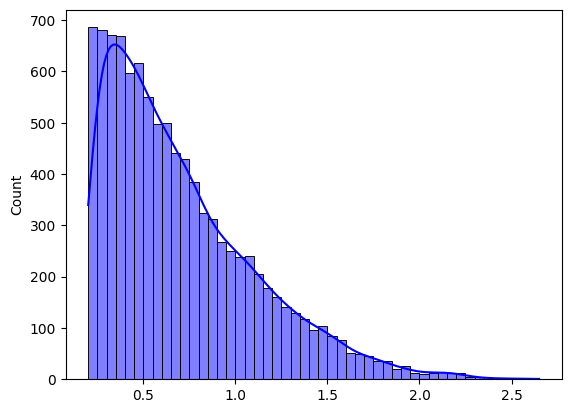

In [385]:
## Object Shape

# unifrom sampling
n = 10000
a = 1.1
b = 5
dist = Beta(a, b)
shift = dist.sample((n,1)).squeeze()
#sns.histplot(shift[:,0].cpu().numpy(), label='joint 1', color='blue', kde=True)

max_block_size = torch.tensor([0.6, 0.2, 0.2])     # Height, W/H ratio, L/H ratio 
min_block_size = torch.tensor([0.05, 3.0, 3.0])

#sizes = 0.05 + (0.6 - 0.05) * shift

sizes = 0.2 + (3.0 - 0.2) * shift


ind = 0
sns.histplot(sizes[:].cpu().numpy(), label='joint 1', color='blue', kde=True)

# edge case sampling using beta distributio


In [4]:
def sample_beta(n: int, x_min:float, x_max:float, alpha=1, beta=1) -> torch.Tensor:
    """Sample from a beta distribution and scale to a given range."""
    # Sample from a beta distribution
    beta_dist = Beta(alpha, beta)
    samples = beta_dist.sample((n,1))
    # Scale the samples to the desired range
    scaled_samples = samples * (x_max - x_min) + x_min
    return scaled_samples

x = sample_beta(10000, 0.2, 3, alpha=1.1, beta=5)
sns.histplot(x[:].cpu().numpy(), label='joint 1', color='blue', kde=True)

NameError: name 'Beta' is not defined

## Evaluation Trajectories

In [2]:
nstates = 14
nEnvs = 512
eval_states = torch.empty((nEnvs, nstates))
# eval_states = torch.cat([init_joint_pos, target_pos, object_size_updated, object_color, friction.unsqueeze(-1)], dim=-1)

##### Object (Size & Color & physical props.)

In [7]:
unseen = True
MaxSize = [0.60,3.0,4]   #Height, W/H, L/H
MinSize = [0.05,0.2,0.25]
if unseen:
    MaxSize = [1.0,3.0,4]   #Height, W/H, L/H
    MinSize = [0.06,0.2,0.25]
    
n = eval_states.shape[0]
object_height = sample_beta(n, MinSize[0], MaxSize[0], alpha=1.5, beta=1.1).squeeze()
object_width =  sample_beta(n, MinSize[1], MaxSize[1], alpha=1.1, beta=5.0).squeeze()
object_length = sample_beta(n, MinSize[2], MaxSize[2], alpha=1.0, beta=1.0).squeeze()

object_size = torch.stack([object_height, object_width, object_length], dim=-1)

object_color = torch.rand((nEnvs, 3))
object_friction = torch.rand((nEnvs, 1))*0.9 + 0.1



##### Initial Joint Position

In [8]:
init_joint_pos = torch.tensor([[0.0, -torch.pi / 4, torch.pi / 2, -torch.pi / 4, torch.pi / 2, 0.0]]).repeat(nEnvs, 1)
a = 5
b = 1
betaDist = Beta(a, b)
joint1PosShift_1 = torch.pi * (betaDist.sample((nEnvs,)).squeeze() - 0.5)
joint1PosShift_2 = -torch.pi * (betaDist.sample((nEnvs,)).squeeze() - 0.5)
sampledShift = torch.where(torch.rand(nEnvs) > 0.5, joint1PosShift_1, joint1PosShift_2)
init_joint_pos[:, 0] = init_joint_pos[:, 0] + sampledShift

angle = math.pi / 4 *torch.rand_like(init_joint_pos[:, 0])
coeff1 = 2 * torch.rand_like(init_joint_pos[:, 0]) - 1 # why not  torch.rand_like(init_joint_pos[:, 0])
coeff2 = 2 * torch.rand_like(init_joint_pos[:, 0]) - 1
coeff3 = coeff1 + coeff2
init_joint_pos[:, 1] += coeff1 * angle
init_joint_pos[:, 3] += coeff2 * angle
init_joint_pos[:, 2] -= coeff3 * angle

print("min init Joint pos new: ", init_joint_pos.min(0).values)
print("max init Joint pos new: ", init_joint_pos.max(0).values)



min init Joint pos new:  tensor([-1.5700, -1.4971,  0.2365, -1.5564,  1.5708,  0.0000])
max init Joint pos new:  tensor([ 1.5614, -0.0984,  2.9707, -0.0173,  1.5708,  0.0000])


##### Target Position


In [9]:
tgt_radius_range = (0.6,0.9) #0.9 is the max radius
tgt_yaw_range = (-math.pi / 2, math.pi / 2)
tgt_pitch_range = (-math.pi / 12, math.pi / 6) # orignally -math.pi / 6, math.pi / 6 --> for safety range changed to -math.pi / 12, 3*math.pi / 12

tgt_radius = torch.empty(nEnvs).uniform_(*tgt_radius_range)
tgt_pitch = torch.empty(nEnvs).uniform_(*tgt_pitch_range)

tgt_yaw_set = torch.empty((nEnvs,10)).uniform_(*tgt_yaw_range)
joint1_pos = init_joint_pos[:, 0].unsqueeze(1).repeat(1, 10)
distance = torch.abs(tgt_yaw_set - joint1_pos)
tgt_yaw = tgt_yaw_set[torch.arange(nEnvs), distance.argmax(dim=-1)]

x = tgt_radius * torch.cos(tgt_yaw) * torch.cos(tgt_pitch)
y = tgt_radius * torch.sin(tgt_yaw) * torch.cos(tgt_pitch)
z = tgt_radius * torch.sin(tgt_pitch)
target_pos = torch.stack([x,y,z], dim=-1)



In [10]:
eval_states = torch.cat([init_joint_pos, target_pos, object_size, object_color, object_friction], dim=-1)

torch.save(eval_states, "Evaluation_States_UnseenTall.pt")

In [392]:
## Real World Qunatitative Eval
import numpy as np
tgt_radius = np.array([0.6, 0.7, 0.8, 0.9]) # N=5
tgt_pitch = np.array([-np.pi/12, 0,  np.pi/12, np.pi/6]) # M=4
tgt_yaw = np.array([np.pi/2]) # L=3

# CW
start_yaw = np.array([np.pi/2]) # K=3
# Create meshgrid of spherical coordinates
R, P, Y = np.meshgrid(tgt_radius, tgt_pitch, tgt_yaw)
# Convert spherical to Cartesian coordinates
X = R * np.cos(P) * np.cos(Y)
Y = R * np.cos(P) * np.sin(Y)
Z = R * np.sin(P)

# Reshape into Nx3 array of xyz coordinates
goal_positions = np.column_stack((X.flatten(), Y.flatten(), Z.flatten()))
goal_positions_ccw = np.round(goal_positions, decimals=5).copy()

# CCW
start_yaw = np.array([-np.pi/2]) # K=3
# Create meshgrid of spherical coordinates
R, P, Y = np.meshgrid(tgt_radius, tgt_pitch, start_yaw)
# Convert spherical to Cartesian coordinates
X = R * np.cos(P) * np.cos(Y)
Y = R * np.cos(P) * np.sin(Y)
Z = R * np.sin(P)
# Reshape into Nx3 array of xyz coordinates
goal_positions = np.column_stack((X.flatten(), Y.flatten(), Z.flatten()))
# Round the goal positions to 5 decimal places
goal_positions_cw = np.round(goal_positions, decimals=5)

# Generate random indices for shuffling while maintaining pairs
n_positions = len(goal_positions_ccw)
shuffle_indices1 = np.random.permutation(n_positions)
shuffle_indices2 = np.random.permutation(n_positions)

# Create interleaved positions array and shuffle using the indices
interleaved_positions = np.empty((goal_positions_ccw.shape[0] + goal_positions_cw.shape[0], 3))
interleaved_positions[0::2] = goal_positions_ccw[shuffle_indices1]
interleaved_positions[1::2] = goal_positions_cw[shuffle_indices2]
print(f"Shape of interleaved positions: {interleaved_positions.shape}")
print(f"Interleaved positions: {interleaved_positions}")

# Save the interleaved positions to a file


Shape of interleaved positions: (32, 3)
Interleaved positions: [[ 0.       0.67615 -0.18117]
 [ 0.      -0.67615  0.18117]
 [ 0.       0.77274 -0.20706]
 [ 0.      -0.77942  0.45   ]
 [ 0.       0.6      0.     ]
 [ 0.      -0.57956  0.15529]
 [ 0.       0.51962  0.3    ]
 [ 0.      -0.8      0.     ]
 [ 0.       0.69282  0.4    ]
 [ 0.      -0.60622  0.35   ]
 [ 0.       0.77942  0.45   ]
 [ 0.      -0.7      0.     ]
 [ 0.       0.60622  0.35   ]
 [ 0.      -0.67615 -0.18117]
 [ 0.       0.8      0.     ]
 [ 0.      -0.86933  0.23294]
 [ 0.       0.57956  0.15529]
 [ 0.      -0.77274  0.20706]
 [ 0.       0.7      0.     ]
 [ 0.      -0.69282  0.4    ]
 [ 0.       0.67615  0.18117]
 [ 0.      -0.77274 -0.20706]
 [ 0.       0.57956 -0.15529]
 [ 0.      -0.86933 -0.23294]
 [ 0.       0.9      0.     ]
 [ 0.      -0.6      0.     ]
 [ 0.       0.86933 -0.23294]
 [ 0.      -0.57956 -0.15529]
 [ 0.       0.86933  0.23294]
 [ 0.      -0.51962  0.3    ]
 [ 0.       0.77274  0.20706]
 [ 0.  

In [393]:
initPos = np.array([
        [ 0.  , -0.79,  1.57, -0.79,  1.57,  0.  ],
        [ 0.99, -1.15,  1.56, -0.35, -0.12, -0.01],
        [-2.01, -0.  ,  0.95, -0.89,  0.2 ,  0.  ],
        [ 0.99, -0.54,  1.56, -0.97, -0.31,  0.  ],
        [-1.95,  0.25,  0.42, -0.67,  0.42,  0.05],
        [ 1.05, -0.11,  1.19, -1.04, -0.1 ,  0.  ],
        [-2.08, -1.03,  1.23, -0.07,  0.03, -0.05],
        [ 1.15, -0.95,  0.98, -0.04,  0.37, -0.03],
        [-2.1 , -0.83,  1.51, -0.5 ,  0.02, -0.08],
        [ 1.21, -0.18,  0.71, -0.55,  0.44,  0.01],
        [-1.94, -0.13,  0.57, -0.46,  0.25,  0.07],
        [ 1.07, -0.45,  1.32, -0.82, -0.08,  0.01],
        [-2.08, -0.48,  1.41, -0.76,  0.05, -0.07],
        [ 1.07, -1.07,  1.3 , -0.21,  0.12, -0.03],
        [-2.02, -0.83,  0.78,  0.09,  0.11,  0.03],
        [ 1.05, -0.81,  1.48, -0.64, -0.06, -0.  ],
        [-2.17, -0.58,  1.7 , -0.91, -0.09, -0.11],
        [ 1.2 , -0.59,  0.89, -0.31,  0.4 , -0.01],
        [-2.02, -0.68,  1.14, -0.34,  0.08, -0.03],
        [ 0.97, -0.23,  1.45, -1.15, -0.32, -0.01],
        [-2.27, -1.27,  1.9 , -0.41, -0.16, -0.09],
        [ 0.97, -0.86,  1.68, -0.73, -0.31, -0.01],
        [-2.19, -0.92,  1.81, -0.67, -0.1 , -0.11],
        [ 1.21,  0.21,  0.51, -0.73,  0.52, -0.03],
        [-2.09, -0.15,  1.31, -1.03,  0.06, -0.06],
        [ 1.13,  0.03,  0.89, -0.88,  0.18, -0.03],
        [-2.16, -1.17,  1.59, -0.24, -0.04, -0.08],
        [ 1.15, -0.34,  1.05, -0.67,  0.17, -0.01],
        [-2.19, -0.25,  1.59, -1.14, -0.09, -0.09],
        [ 0.89, -1.2 ,  1.78, -0.51, -0.36, -0.  ],
        [-2.  , -0.35,  1.06, -0.62,  0.15, -0.01],
        [ 1.13, -0.71,  1.21, -0.48,  0.17, -0.02],
        #[-1.96, -0.48,  0.67, -0.16,  0.16,  0.04],
        ])

#init_joint_pos = torch.tensor([[0.0, -torch.pi / 4, torch.pi / 2, -torch.pi / 4, torch.pi / 2, 0.0]]).repeat(nEnvs, 1)


initPos[:,5] = 0.0
initPos[:,4] = np.pi / 2
initPos[:,2] = -(initPos[:,1] + initPos[:,3])
initPos[:,0] = np.clip(initPos[:,0], -np.pi/2, np.pi/2)

# find initPos[:,2]
#initPos[:,1] =  -np.pi / 4 + coeff1 * angle
#initPos[:,3] =  -np.pi / 4 + coeff2 * angle
#initPos[:,2] =  np.pi / 2 - coeff1*angle - coeff2 * angle
#initPos[:,2] =  np.pi/2 - (initPos[:,1]+np.pi/4) - (initPos[:,3]+np.pi/4)


In [394]:
nstates = 14
nEnvs = interleaved_positions.shape[0]
eval_states = torch.empty((nEnvs, nstates))

unseen = False
MaxSize = [0.60,3.0,4]   #Height, W/H, L/H
MinSize = [0.05,0.2,0.25]
if unseen:
    MaxSize = [0.80,3.0,4]   #Height, W/H, L/H
    MinSize = [0.6,0.2,0.25]
    
n = eval_states.shape[0]
object_height = sample_beta(n, MinSize[0], MaxSize[0], alpha=1.5, beta=1.1).squeeze()
object_width =  sample_beta(n, MinSize[1], MaxSize[1], alpha=1.1, beta=5.0).squeeze()
object_length = sample_beta(n, MinSize[2], MaxSize[2], alpha=1.0, beta=1.0).squeeze()

object_size = torch.stack([object_height, object_width, object_length], dim=-1)

object_color = torch.rand((nEnvs, 3))
object_friction = torch.rand((nEnvs, 1))*0.9 + 0.1

#init_joint_pos = torch.tensor([[0.0, -torch.pi / 4, torch.pi / 2, -torch.pi / 4, torch.pi / 2, 0.0]]).repeat(nEnvs, 1)
init_joint_pos = torch.tensor(initPos)

target_pos = torch.tensor(interleaved_positions)

eval_states = torch.cat([init_joint_pos, target_pos, object_size, object_color, object_friction], dim=-1)

torch.save(eval_states, "Evaluation_States_real.pt")